### 1. 주요배급사 추출

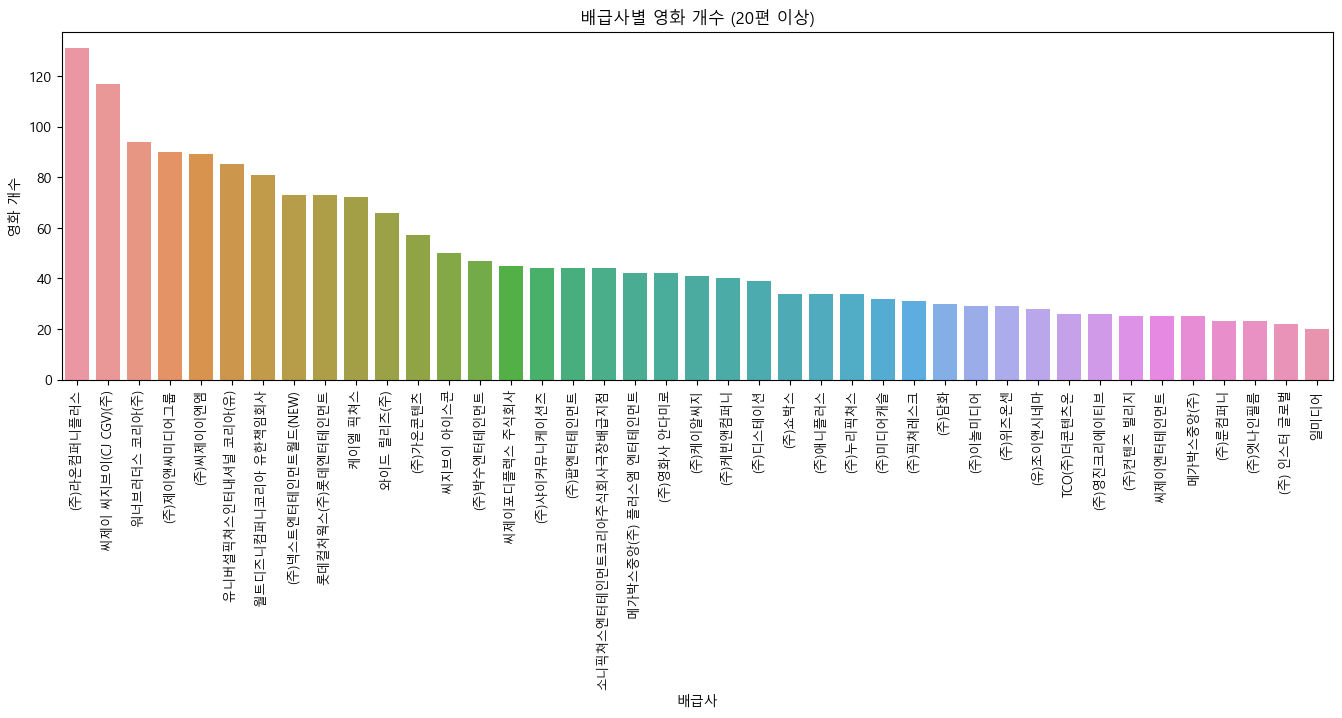

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import matplotlib.font_manager as fm

# 1. 한글 폰트 설정 (Windows 기준)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 2. CSV 불러오기
file_path = "data.csv"  # 경로 수정
df = pd.read_csv(file_path)

# 3. 배급사 NaN을 '기타'로 대체
df["배급사(Null처리)"] = df["배급사"].fillna("기타")

# 4. 콤마로 구분된 배급사 분리 및 리스트 확장
distributor_list = []
for entry in df["배급사(Null처리)"]:
    distributor_list.extend([name.strip() for name in entry.split(",")])

# 5. 카운트 및 시리즈로 변환
distributor_counts = Counter(distributor_list)
distributor_series = pd.Series(distributor_counts)

# 6. '기타' 제외 + 영화 수가 20편 이상인 배급사만 필터링
filtered_series = distributor_series[
    (distributor_series >= 20) & (distributor_series.index != "기타")
].sort_values(ascending=False)

# 7. 시각화
plt.figure(figsize=(max(14, len(filtered_series) * 0.4), 6))
sns.barplot(x=filtered_series.index, y=filtered_series.values)
plt.title("배급사별 영화 개수 (20편 이상)")
plt.xlabel("배급사")
plt.ylabel("영화 개수")
plt.xticks(rotation=90, fontsize=9)
plt.subplots_adjust(bottom=0.3)
plt.show()

In [9]:
# 주요 배급사: 영화 20편 이상 + '기타' 제외
major_distributors = distributor_series[
    (distributor_series >= 20) & (distributor_series.index != "기타")
]

# 주요 배급사 수 출력
print(f"주요 배급사 수: {len(major_distributors)}개")


주요 배급사 수: 41개


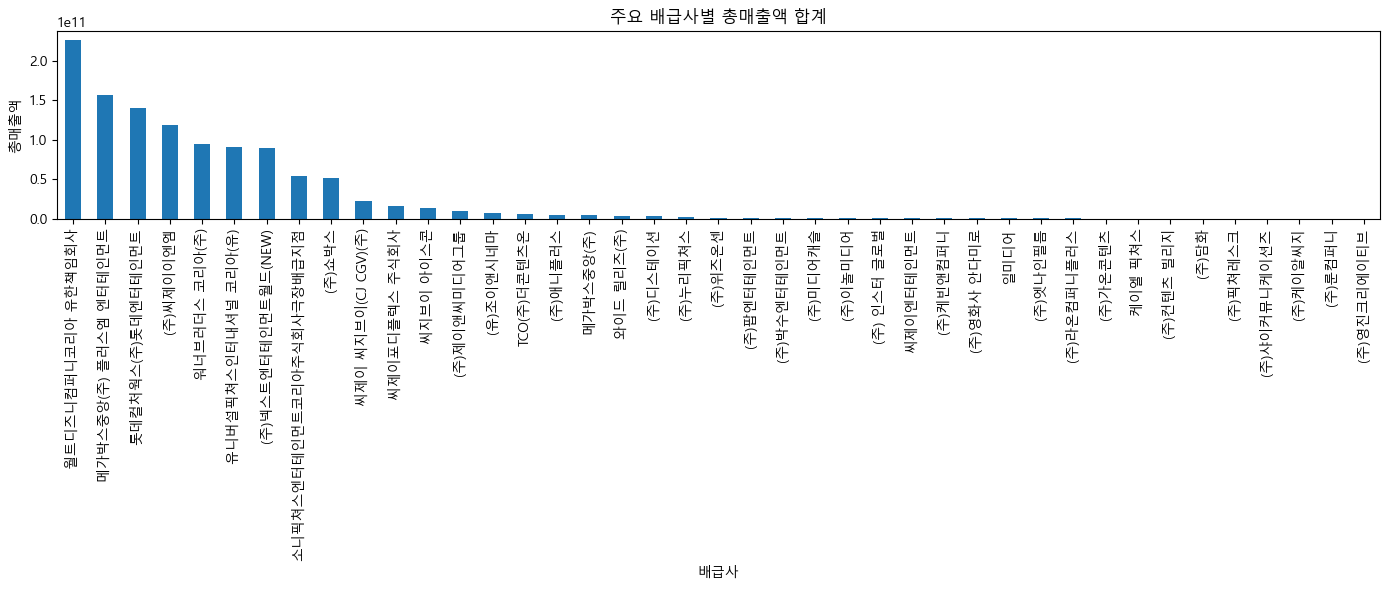

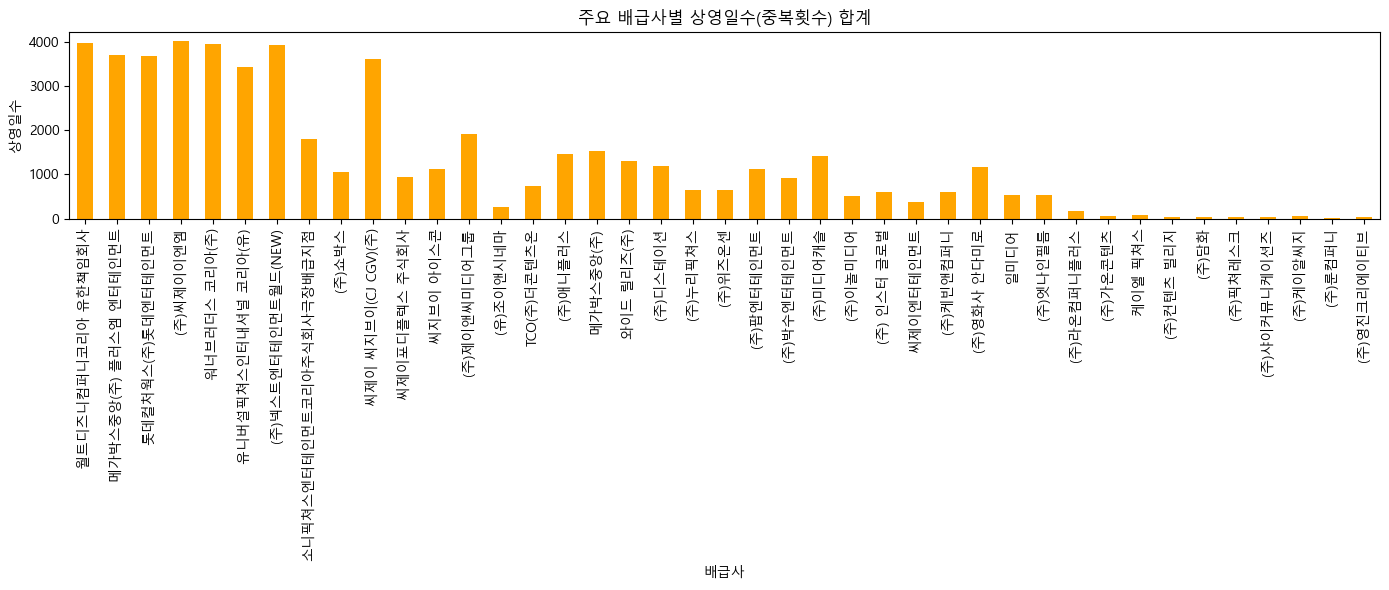

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

# 한글 폰트 설정 (Windows)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 데이터 불러오기
df = pd.read_csv("data.csv")
df["배급사(Null처리)"] = df["배급사"].fillna("기타")

# 배급사 분리 후 주요 배급사 식별
distributor_list = []
for entry in df["배급사(Null처리)"]:
    distributor_list.extend([x.strip() for x in entry.split(",")])
distributor_counts = Counter(distributor_list)
distributor_series = pd.Series(distributor_counts)
major_distributors = distributor_series[
    (distributor_series >= 20) & (distributor_series.index != "기타")
].index.tolist()

# 주요 배급사 관련 행 필터링
def extract_major_distributors(entry):
    if pd.isna(entry):
        return []
    return [x.strip() for x in entry.split(",") if x.strip() in major_distributors]

# 영화별로 주요 배급사 리스트 추출
df["주요_배급사목록"] = df["배급사"].apply(extract_major_distributors)

# 각 주요 배급사별 총매출액 및 중복횟수 집계
rows = []
for _, row in df.iterrows():
    for distributor in row["주요_배급사목록"]:
        rows.append({
            "배급사": distributor,
            "총매출액": row["총매출액"],
            "상영일수": row["상영일수"]
        })

df_major = pd.DataFrame(rows)

# 총매출액, 중복횟수 집계
agg_df = df_major.groupby("배급사")[["총매출액", "상영일수"]].sum().sort_values("총매출액", ascending=False)

# 1. 총매출액 그래프
plt.figure(figsize=(14, 6))
agg_df["총매출액"].plot(kind="bar")
plt.title("주요 배급사별 총매출액 합계")
plt.ylabel("총매출액")
plt.xlabel("배급사")
plt.tight_layout()
plt.show()

# 2. 중복횟수 그래프
plt.figure(figsize=(14, 6))
agg_df["상영일수"].plot(kind="bar", color="orange")
plt.title("주요 배급사별 상영일수(중복횟수) 합계")
plt.ylabel("상영일수")
plt.xlabel("배급사")
plt.tight_layout()
plt.show()


### 상위 50개와 상위30% 비교 
1. 로그 스케일 적용 전
2. 로그 스케일 적용

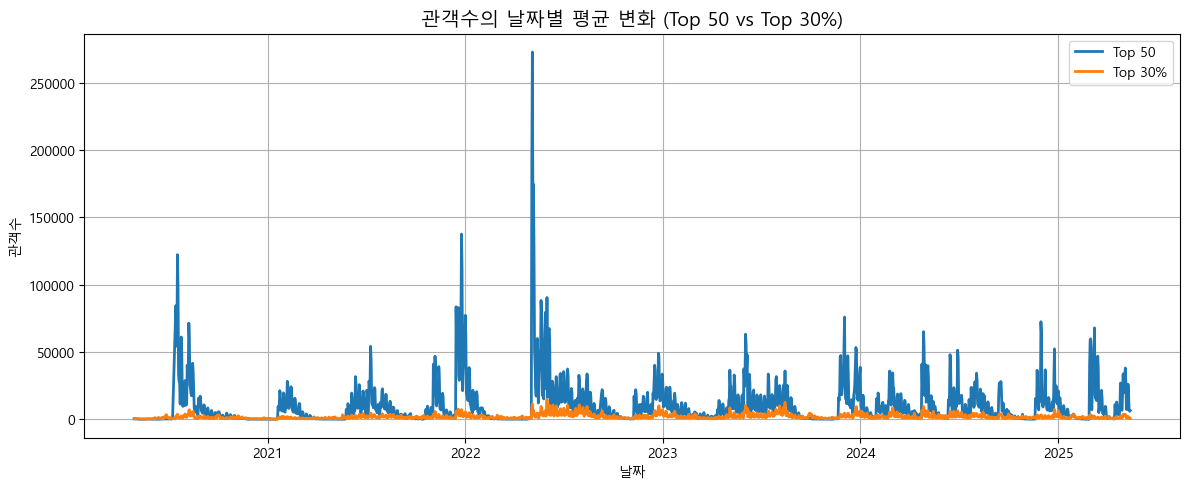

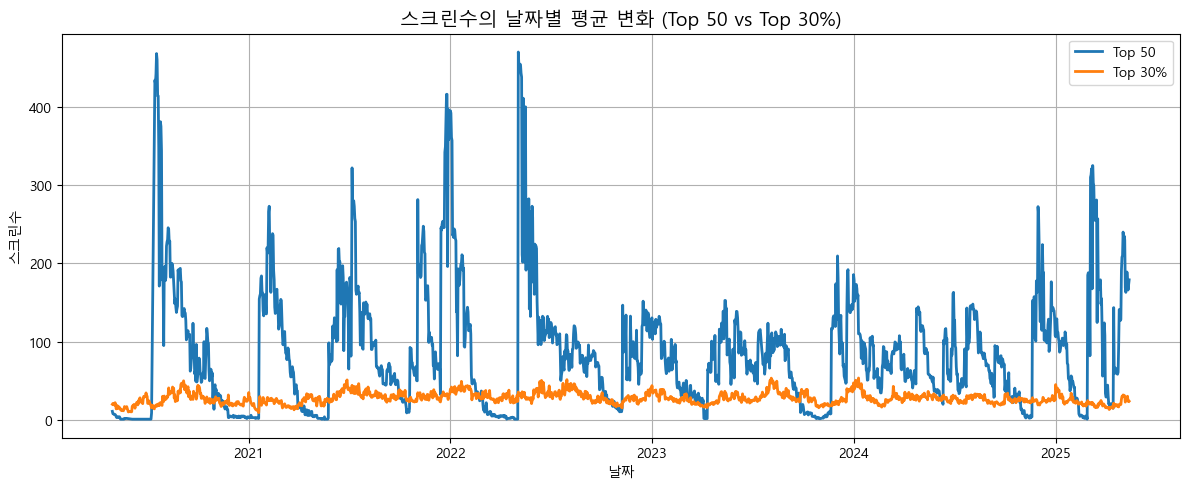

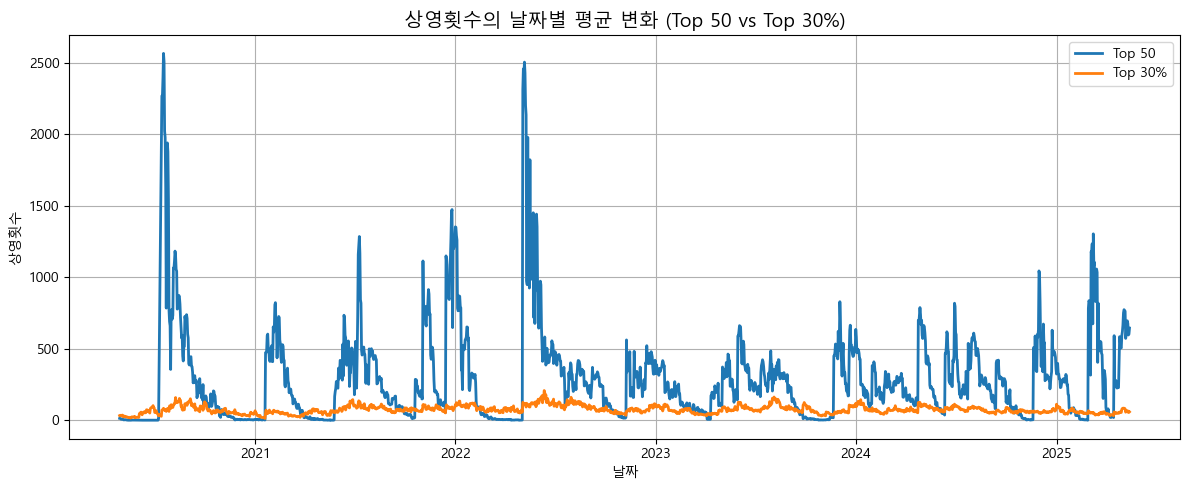

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import ast

# 🔸 한글 폰트 설정 (Windows: 맑은 고딕)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False  # 음수 기호 깨짐 방지

# CSV 불러오기
df = pd.read_csv("data.csv")
df['총매출액'] = pd.to_numeric(df['총매출액'], errors='coerce')

# 상위 50개, 상위 30% 추출
top_50 = df.nlargest(50, '총매출액')
top_30_percent_count = int(len(df) * 0.3)
top_30_percent = df.nlargest(top_30_percent_count, '총매출액')

# 날짜별 평균으로 정리하는 함수
def aggregate_datewise(df_subset, col_name):
    data = []
    for _, row in df_subset.iterrows():
        try:
            dates = ast.literal_eval(row['날짜']) if isinstance(row['날짜'], str) else []
            values = ast.literal_eval(row[col_name]) if isinstance(row[col_name], str) else []
            for date, val in zip(dates, values):
                data.append((date, val))
        except:
            continue
    result_df = pd.DataFrame(data, columns=['날짜', col_name])
    result_df['날짜'] = pd.to_datetime(result_df['날짜'], errors='coerce')
    return result_df.groupby('날짜')[col_name].mean().sort_index()

# 시각화할 열 목록
cols_to_plot = ['관객수', '스크린수', '상영횟수']

# 시각화
for col in cols_to_plot:
    top_agg = aggregate_datewise(top_50, col)
    top30_agg = aggregate_datewise(top_30_percent, col)

    plt.figure(figsize=(12, 5))
    plt.plot(top_agg.index, top_agg.values, label='Top 50', linewidth=2)
    plt.plot(top30_agg.index, top30_agg.values, label='Top 30%', linewidth=2)
    plt.title(f'{col}의 날짜별 평균 변화 (Top 50 vs Top 30%)', fontsize=14)
    plt.xlabel('날짜')
    plt.ylabel(col)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


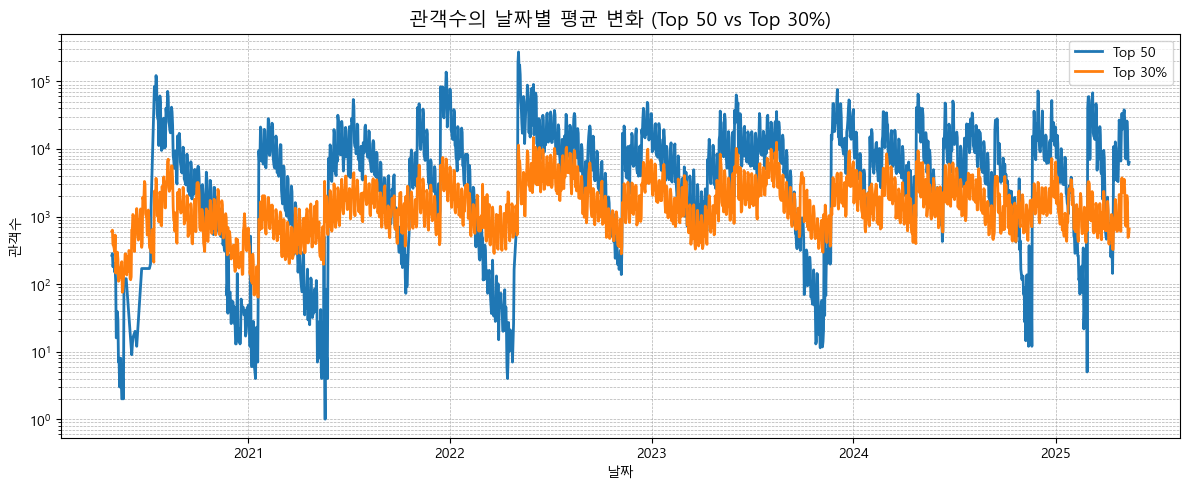

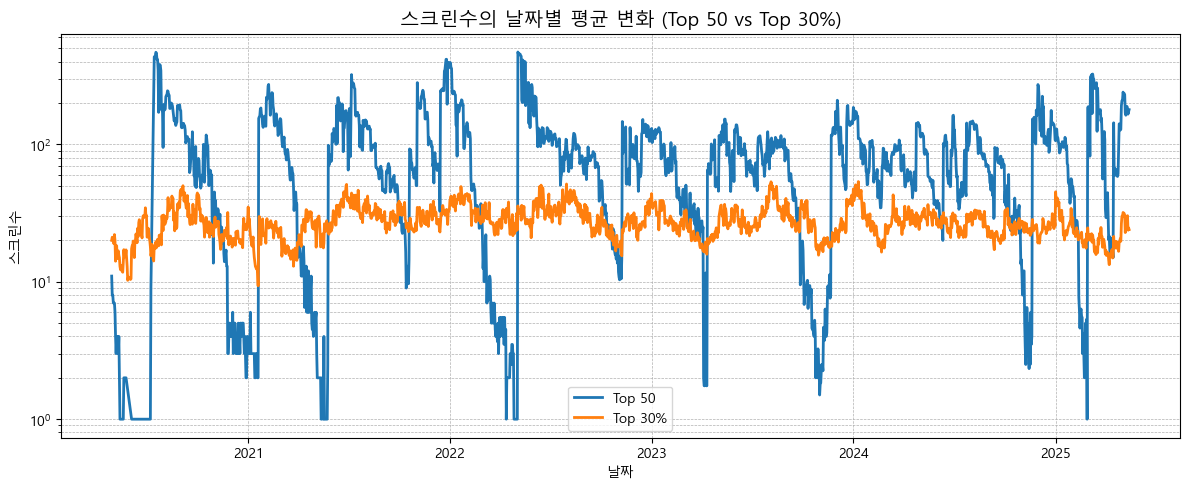

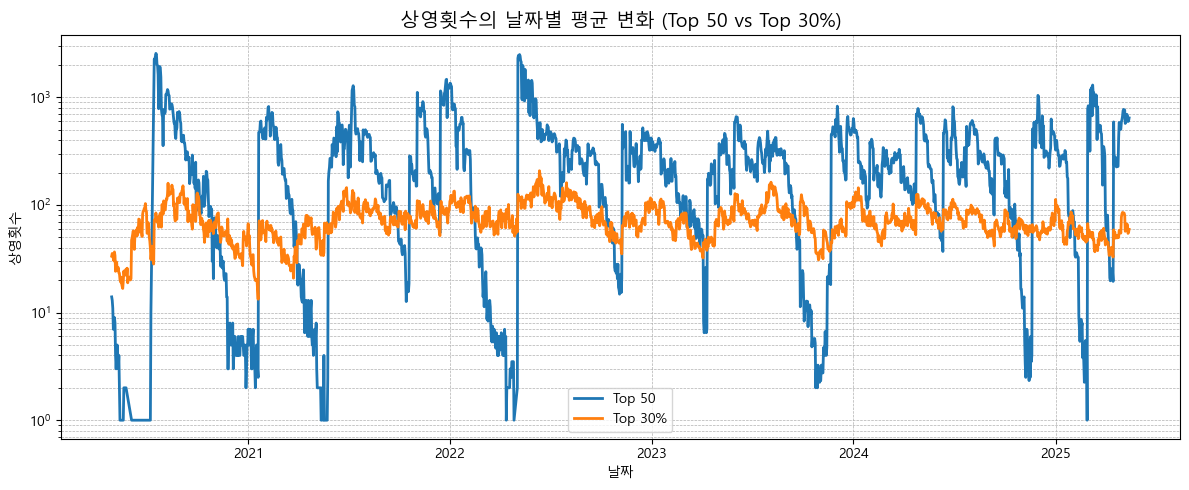

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import ast

# 🔸 한글 폰트 설정 (Windows: 맑은 고딕)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False  # 음수 기호 깨짐 방지

# CSV 불러오기
df = pd.read_csv("data.csv")
df['총매출액'] = pd.to_numeric(df['총매출액'], errors='coerce')

# 상위 50개, 상위 30% 추출
top_50 = df.nlargest(50, '총매출액')
top_30_percent_count = int(len(df) * 0.3)
top_30_percent = df.nlargest(top_30_percent_count, '총매출액')

# 날짜별 평균으로 정리하는 함수
def aggregate_datewise(df_subset, col_name):
    data = []
    for _, row in df_subset.iterrows():
        try:
            dates = ast.literal_eval(row['날짜']) if isinstance(row['날짜'], str) else []
            values = ast.literal_eval(row[col_name]) if isinstance(row[col_name], str) else []
            for date, val in zip(dates, values):
                data.append((date, val))
        except:
            continue
    result_df = pd.DataFrame(data, columns=['날짜', col_name])
    result_df['날짜'] = pd.to_datetime(result_df['날짜'], errors='coerce')
    return result_df.groupby('날짜')[col_name].mean().sort_index()

# 시각화할 열 목록
cols_to_plot = ['관객수', '스크린수', '상영횟수']

# 시각화
for col in cols_to_plot:
    top_agg = aggregate_datewise(top_50, col)
    top30_agg = aggregate_datewise(top_30_percent, col)

    plt.figure(figsize=(12, 5))
    plt.plot(top_agg.index, top_agg.values, label='Top 50', linewidth=2)
    plt.plot(top30_agg.index, top30_agg.values, label='Top 30%', linewidth=2)
    plt.title(f'{col}의 날짜별 평균 변화 (Top 50 vs Top 30%)', fontsize=14)
    plt.xlabel('날짜')
    plt.ylabel(col)
    plt.yscale('log')  # 🔹 로그 스케일 적용
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()


### 각 그래프에서 급감하는 구간에 대한 분석 필요

### 관객 수 급감 요인 분석 (1년치)

- 기준 1: 전일대비 관객수가 50% 하락
- 기준 2: 전일대비 스크린수가 50% 하락
- 기준 3: 전일대비 상영횟수가 50% 하락


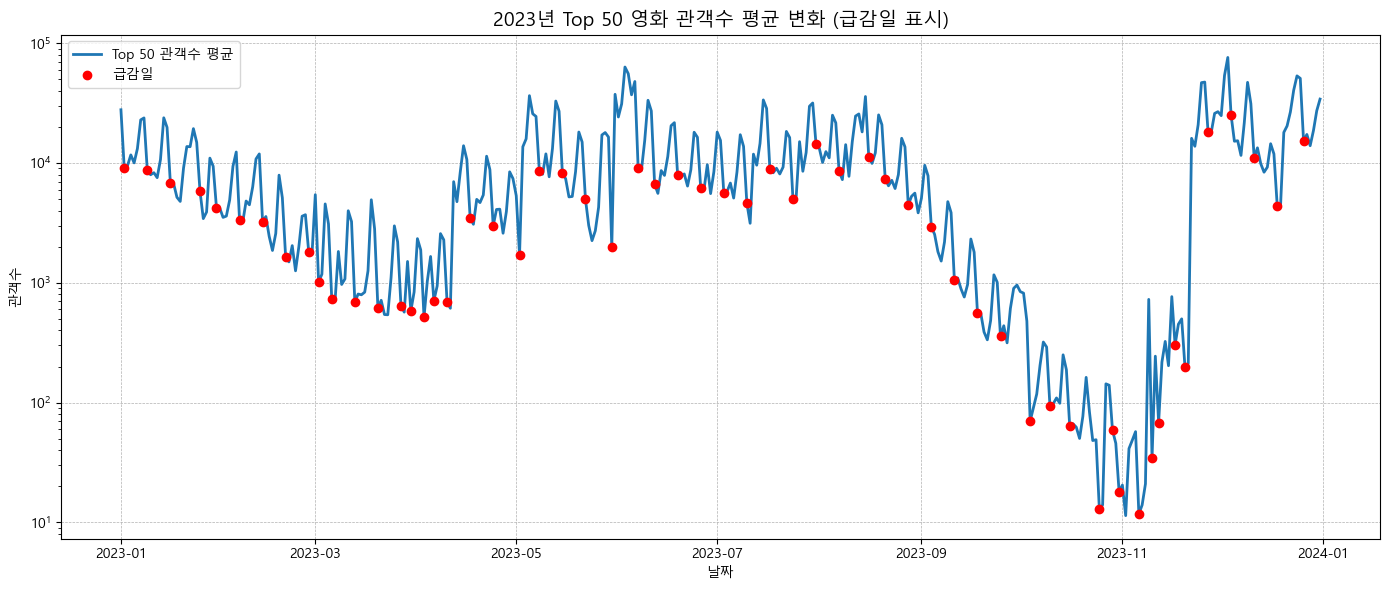

📉 관객수 급감 날짜 요약:
           날짜       관객수 평균값         요일   월
0  2023-01-02   9094.333333     Monday   1
1  2023-01-09   8691.800000     Monday   1
2  2023-01-16   6839.800000     Monday   1
3  2023-01-25   5816.200000  Wednesday   1
4  2023-01-30   4223.400000     Monday   1
5  2023-02-06   3355.666667     Monday   2
6  2023-02-13   3227.800000     Monday   2
7  2023-02-20   1636.714286     Monday   2
8  2023-02-27   1811.400000     Monday   2
9  2023-03-02   1012.333333   Thursday   3
10 2023-03-06    726.428571     Monday   3
11 2023-03-13    690.500000     Monday   3
12 2023-03-20    620.400000     Monday   3
13 2023-03-27    646.000000     Monday   3
14 2023-03-30    581.000000   Thursday   3
15 2023-04-03    516.250000     Monday   4
16 2023-04-06    708.250000   Thursday   4
17 2023-04-10    689.750000     Monday   4
18 2023-04-17   3485.000000     Monday   4
19 2023-04-24   2981.750000     Monday   4
20 2023-05-02   1703.200000    Tuesday   5
21 2023-05-08   8646.250000     Monday

In [8]:
# 기준 1: 전일대비 관객수가 50% 하락


import pandas as pd
import matplotlib.pyplot as plt
import ast

# 🔸 한글 폰트 설정 (Windows: 맑은 고딕)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False  # 음수 기호 깨짐 방지

# 🔸 CSV 불러오기
df = pd.read_csv("data.csv")
df['총매출액'] = pd.to_numeric(df['총매출액'], errors='coerce')

# 🔸 상위 50개, 상위 30% 추출
top_50 = df.nlargest(50, '총매출액')
top_30_percent_count = int(len(df) * 0.3)
top_30_percent = df.nlargest(top_30_percent_count, '총매출액')

# 🔸 날짜별 평균으로 정리하는 함수
def aggregate_datewise(df_subset, col_name):
    data = []
    for _, row in df_subset.iterrows():
        try:
            dates = ast.literal_eval(row['날짜']) if isinstance(row['날짜'], str) else []
            values = ast.literal_eval(row[col_name]) if isinstance(row[col_name], str) else []
            for date, val in zip(dates, values):
                data.append((date, val))
        except:
            continue
    result_df = pd.DataFrame(data, columns=['날짜', col_name])
    result_df['날짜'] = pd.to_datetime(result_df['날짜'], errors='coerce')
    return result_df.groupby('날짜')[col_name].mean().sort_index()

# 🔸 변화량 급감 시점 탐지 함수
def find_drop_dates(series, threshold=-0.5):
    pct_change = series.pct_change()
    drop_dates = pct_change[pct_change < threshold].index
    return drop_dates

# 🔸 급감 날짜 정보 출력 함수
def annotate_drop_dates(series, drop_dates):
    drop_info = []
    for date in drop_dates:
        val = series.loc[date]
        drop_info.append({
            '날짜': date,
            '관객수 평균값': val,
            '요일': date.strftime('%A'),
            '월': date.month
        })
    return pd.DataFrame(drop_info)

# 🔸 분석할 날짜 범위 설정 (2023년 1년치)
start_date = pd.to_datetime("2023-01-01")
end_date = pd.to_datetime("2023-12-31")

# 🔸 관객수 기준 날짜별 평균
top_viewers = aggregate_datewise(top_50, '관객수')
top_viewers = top_viewers[(top_viewers.index >= start_date) & (top_viewers.index <= end_date)]

# 🔸 급감일 탐지 및 정보 요약
drop_dates = find_drop_dates(top_viewers, threshold=-0.5)
drop_info_df = annotate_drop_dates(top_viewers, drop_dates)

# 🔸 시각화 (급감 표시 포함)
plt.figure(figsize=(14, 6))
plt.plot(top_viewers.index, top_viewers.values, label='Top 50 관객수 평균', linewidth=2)
plt.scatter(drop_dates, top_viewers.loc[drop_dates], color='red', label='급감일', zorder=5)
plt.title('2023년 Top 50 영화 관객수 평균 변화 (급감일 표시)', fontsize=14)
plt.xlabel('날짜')
plt.ylabel('관객수')
plt.yscale('log')
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

# 🔸 급감일 표 출력
print("📉 관객수 급감 날짜 요약:")
print(drop_info_df)


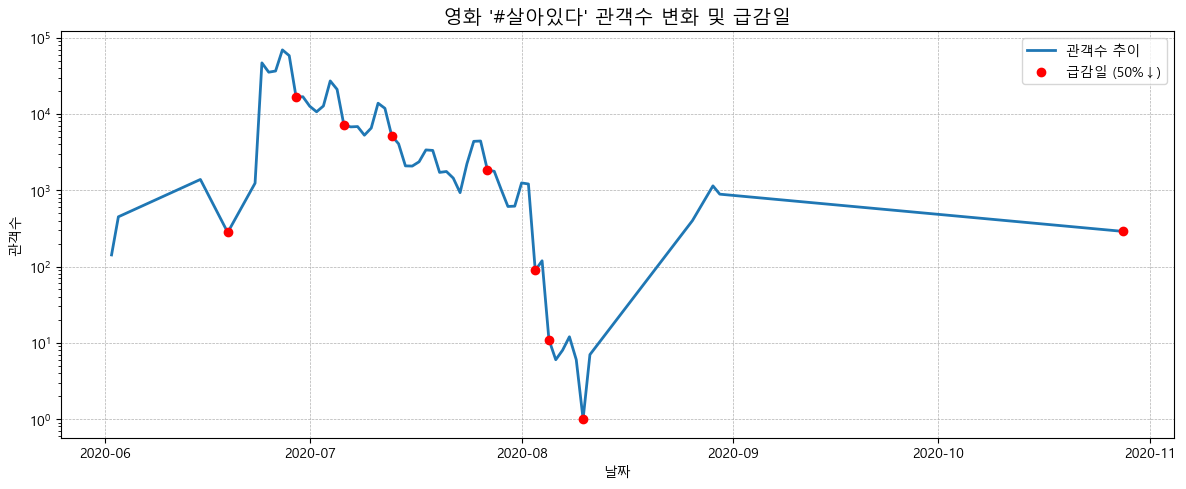

🎬 '#살아있다' 급감일 요약:
          날짜    관객수       감소율  상영 시작으로부터 경과일         요일   월
0 2020-06-19    280 -0.797980             17     Friday   6
1 2020-06-29  16743 -0.712571             27     Monday   6
2 2020-07-06   7164 -0.659587             34     Monday   7
3 2020-07-13   5163 -0.565111             41     Monday   7
4 2020-07-27   1845 -0.583145             55     Monday   7
5 2020-08-03     89 -0.926385             62     Monday   8
6 2020-08-05     11 -0.907563             64  Wednesday   8
7 2020-08-10      1 -0.833333             69     Monday   8
8 2020-10-28    289 -0.674916            148  Wednesday  10


In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import ast

# 🔸 한글 폰트 설정 (Windows: 맑은 고딕)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 🔸 데이터 불러오기
df = pd.read_csv("data.csv")

# 🔸 '#살아있다' 영화만 필터링
movie_title = "#살아있다"
movie_row = df[df['영화명'] == movie_title]

if movie_row.empty:
    raise ValueError(f"영화 '{movie_title}'를 찾을 수 없습니다.")

# 🔸 날짜 및 관객수 추출
dates = ast.literal_eval(movie_row.iloc[0]['날짜']) if isinstance(movie_row.iloc[0]['날짜'], str) else []
viewers = ast.literal_eval(movie_row.iloc[0]['관객수']) if isinstance(movie_row.iloc[0]['관객수'], str) else []

# 🔸 시계열로 변환
series = pd.Series(viewers, index=pd.to_datetime(dates))
series = series.sort_index()

# 🔸 상영 시작일
start_date = series.index[0]

# 🔸 급감일 탐지 (50% 이상 하락)
pct_change = series.pct_change()
drop_dates = pct_change[pct_change < -0.5].index

# 🔸 결과 테이블 생성
drop_info = []
for date in drop_dates:
    drop_info.append({
        '날짜': date,
        '관객수': series[date],
        '감소율': pct_change[date],
        '상영 시작으로부터 경과일': (date - start_date).days,
        '요일': date.strftime('%A'),
        '월': date.month
    })

drop_df = pd.DataFrame(drop_info)

# 🔸 그래프 시각화
plt.figure(figsize=(12, 5))
plt.plot(series.index, series.values, label='관객수 추이', linewidth=2)
plt.scatter(drop_dates, series.loc[drop_dates], color='red', label='급감일 (50%↓)', zorder=5)
plt.title(f"영화 '{movie_title}' 관객수 변화 및 급감일", fontsize=14)
plt.xlabel('날짜')
plt.ylabel('관객수')
plt.yscale('log')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()

# 🔸 결과 출력
print(f"🎬 '{movie_title}' 급감일 요약:")
print(drop_df)


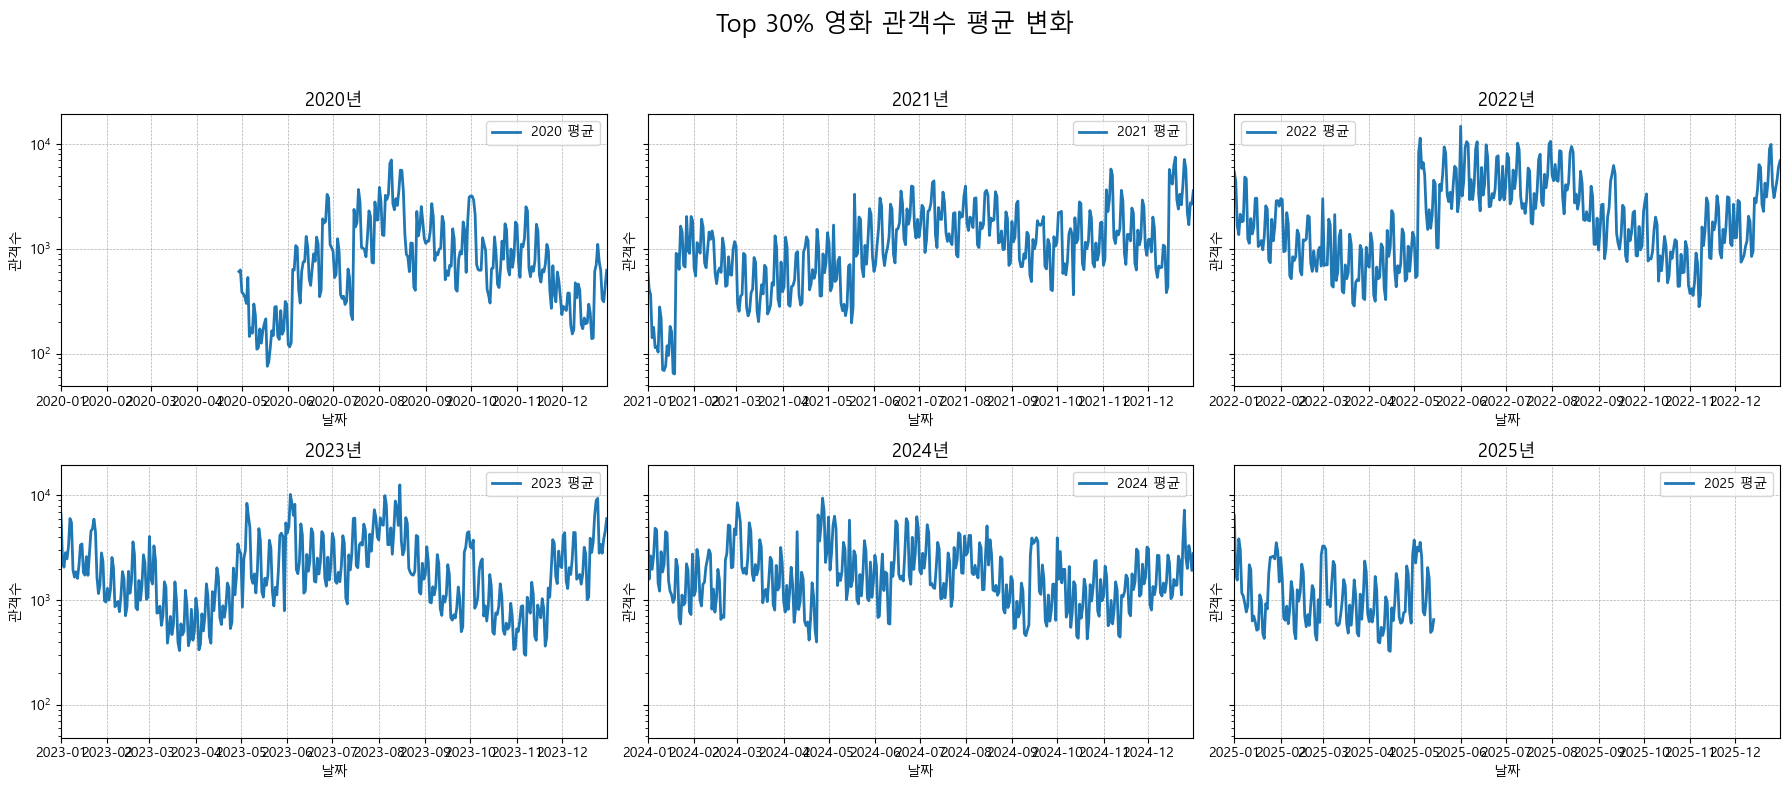

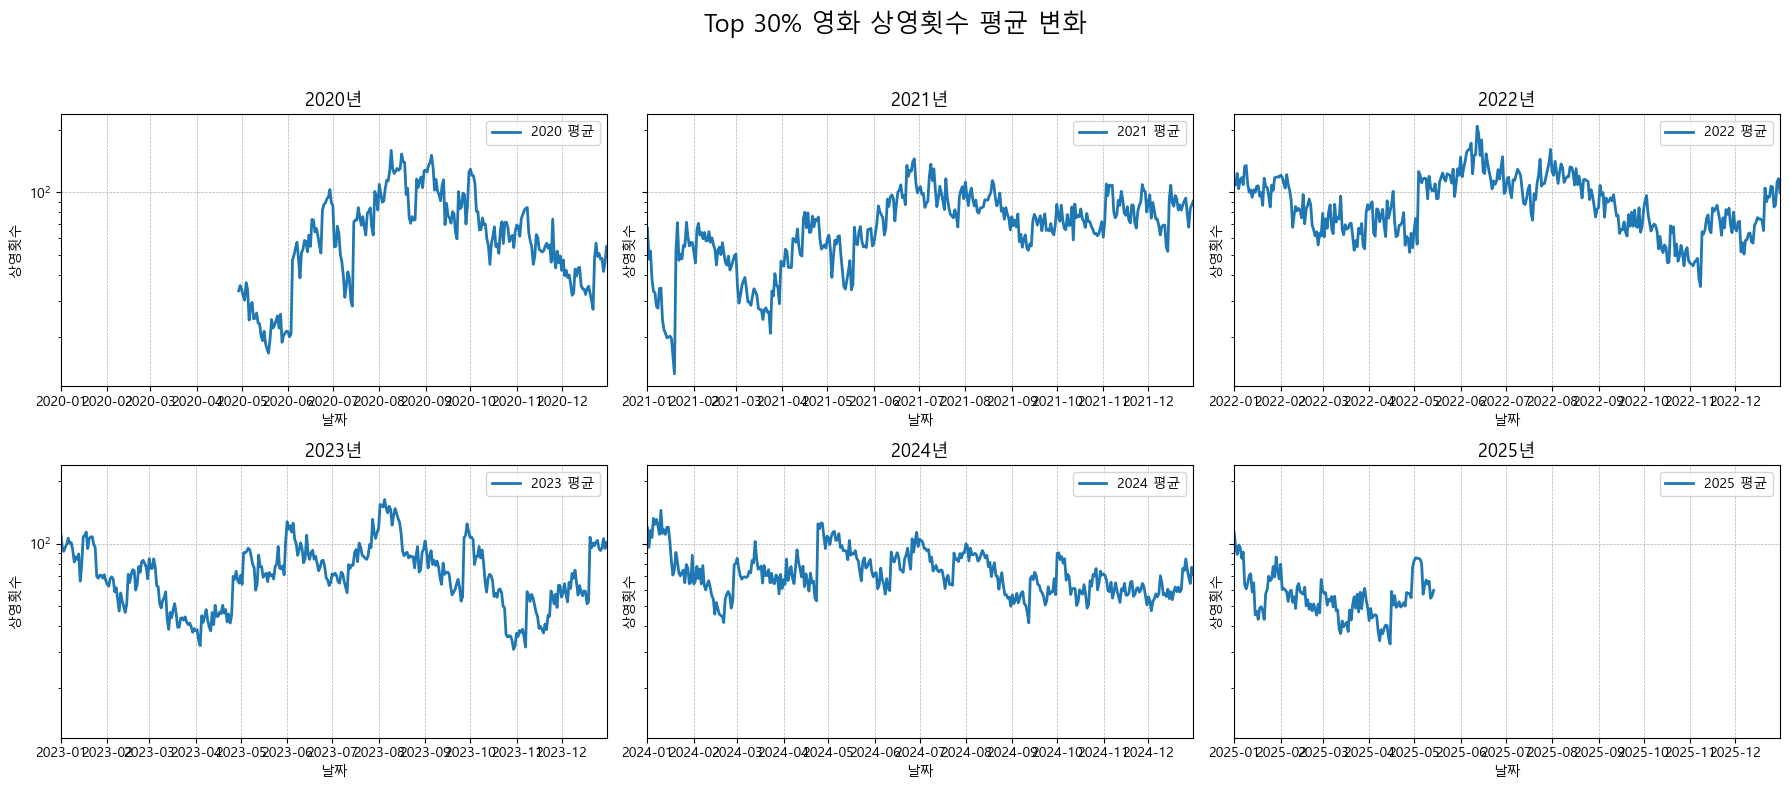

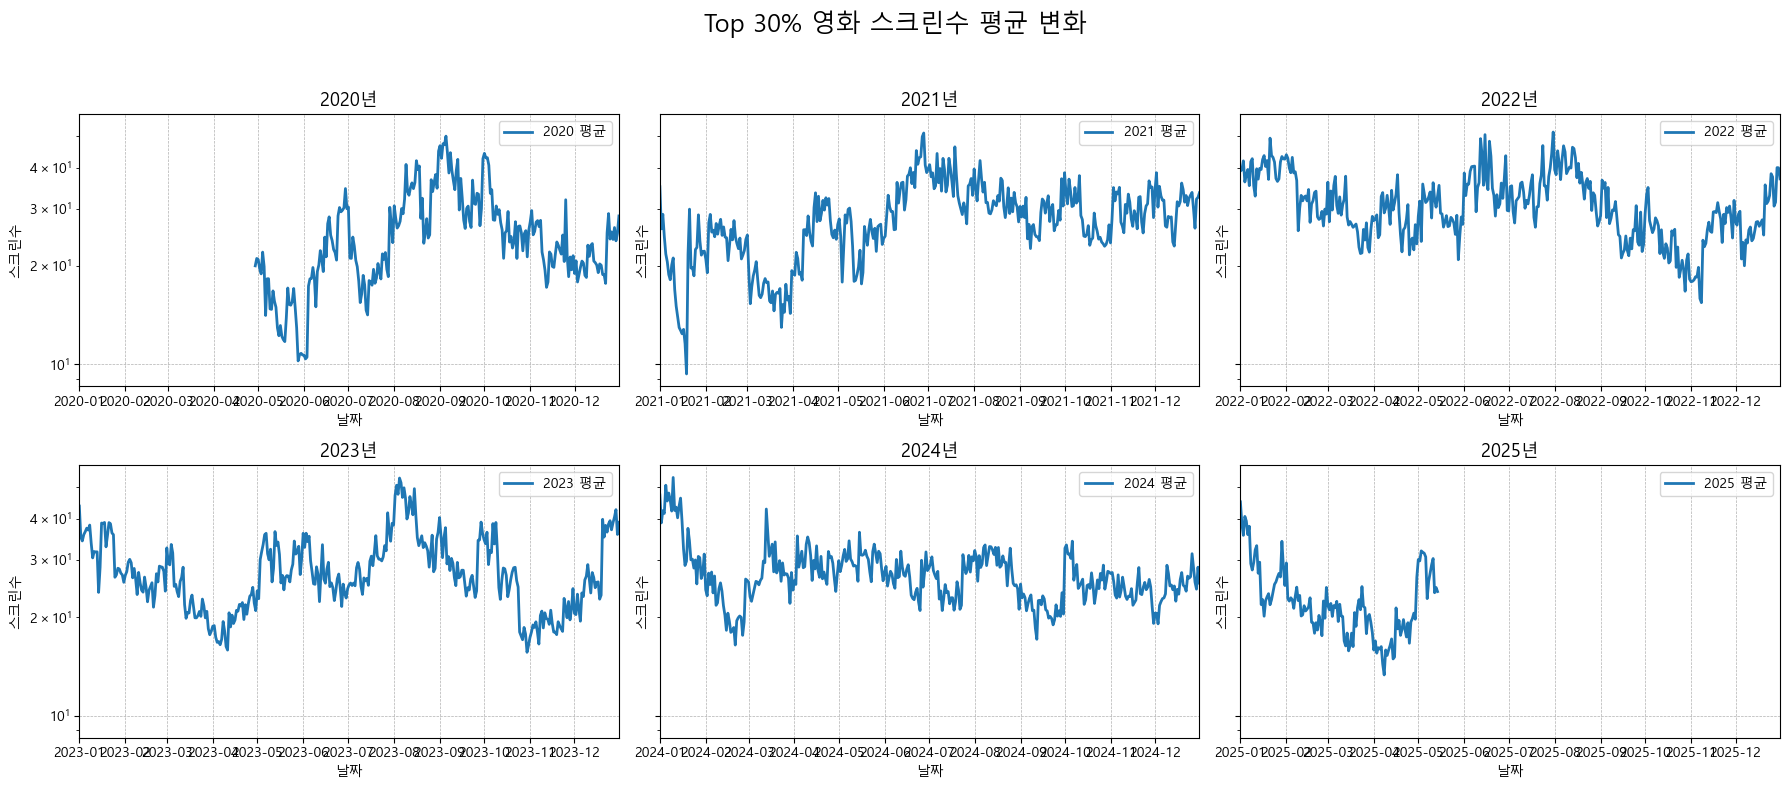

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import ast

# 🔸 한글 폰트 설정 (Windows: 맑은 고딕)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 🔸 CSV 불러오기
df = pd.read_csv("data.csv")
df['총매출액'] = pd.to_numeric(df['총매출액'], errors='coerce')

# 🔸 상위 30% 추출
top_30_percent_count = int(len(df) * 0.3)
top_30_percent = df.nlargest(top_30_percent_count, '총매출액')

# 🔸 날짜별 평균 계산 함수
def aggregate_datewise(df_subset, col_name):
    data = []
    for _, row in df_subset.iterrows():
        try:
            dates = ast.literal_eval(row['날짜']) if isinstance(row['날짜'], str) else []
            values = ast.literal_eval(row[col_name]) if isinstance(row[col_name], str) else []
            for date, val in zip(dates, values):
                data.append((date, val))
        except:
            continue
    result_df = pd.DataFrame(data, columns=['날짜', col_name])
    result_df['날짜'] = pd.to_datetime(result_df['날짜'], errors='coerce')
    return result_df.groupby('날짜')[col_name].mean().sort_index()

# 🔸 급감 탐지 함수
# def find_drop_dates(series, threshold=-0.5):
#     pct_change = series.pct_change()
#     return pct_change[pct_change < threshold].index

# 🔸 연도별 추세 및 급감일 시각화 함수 (3x2 그리드)
def plot_yearly_trends(series, drop_dates, title, y_label):
    years = [2020, 2021, 2022, 2023, 2024, 2025]
    n_rows = 2
    n_cols = 3
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 8), sharey=True)
    axes = axes.flatten()

    for i, year in enumerate(years):
        start = pd.to_datetime(f"{year}-01-01")
        end = pd.to_datetime(f"{year}-12-31")
        full_range = pd.date_range(start=start, end=end)

        # 🔸 시리즈를 연도별로 자르고, 1~12월 전체 범위로 reindex
        yearly_series = series[(series.index >= start) & (series.index <= end)]
        yearly_series = yearly_series.reindex(full_range)

        # 🔸 급감일 중 유효한 날짜만 선택
        yearly_drops = [d for d in drop_dates if start <= d <= end]
        valid_drops = [d for d in yearly_drops if d in yearly_series.index and pd.notna(yearly_series.loc[d])]

        axes[i].plot(yearly_series.index, yearly_series.values, label=f"{year} 평균", linewidth=2)
# axes[i].scatter(valid_drops, yearly_series.loc[valid_drops], color='red', label='급감일', zorder=5)

        axes[i].set_title(f"{year}년", fontsize=13)
        axes[i].set_xlabel('날짜')
        axes[i].set_ylabel(y_label)
        axes[i].set_yscale('log')
        axes[i].grid(True, linestyle='--', linewidth=0.5)
        axes[i].legend()
        axes[i].set_xlim([start, end])  # ✅ x축을 1월 1일부터 고정

    # 🔸 남는 subplot 숨김
    for j in range(len(years), len(axes)):
        fig.delaxes(axes[j])

    fig.suptitle(title, fontsize=18)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# 🔸 분석할 항목 리스트
targets = [
    ("관객수", "Top 30% 영화 관객수 평균 변화", "관객수"),
    ("상영횟수", "Top 30% 영화 상영횟수 평균 변화", "상영횟수"),
    ("스크린수", "Top 30% 영화 스크린수 평균 변화", "스크린수")
]

# 🔸 각 항목별 분석 및 시각화
for col, title, ylabel in targets:
    series = aggregate_datewise(top_30_percent, col)
    drop_dates = find_drop_dates(series)
    plot_yearly_trends(series, drop_dates, title, ylabel)


## 흥행 지속률, 관객감소율, 반감기, 기울기, 재반등 횟수, 일일 평균 관객수

#### 1. 흥행지속률 = 마지막주차 매출 평균 / 첫주차 매출 평균
    (근데 재개봉한 것에 대해서는 흥행 지속률을 어떻게 판단해야할 지 모르겠음)

#### 2. 관객감소율 = 처음 대비 마지막 관객 수의 감소 비율 (음수이면 관객 수가 증가한 것)

#### 3. 반감기 = 최초 관객 수의 절반 이하로 떨어지는 데 걸리는 시간
    (영화의 인기가 잦아드는게 개봉 후 몇일이 지난 시점인지를 파악 가능)

#### 4. 기울기 = 관객수 변화 추세 (음수면 감소)

#### 5. 재반등횟수 = 직전일 대비 관객수가 2배 이상 다시 증가한 횟수

#### 6. 일일평균관객수 = 전체 기간 동안의 평균 관객 수

In [1]:
import pandas as pd
import numpy as np
import ast
from datetime import datetime
from sklearn.linear_model import LinearRegression
from tabulate import tabulate

# CSV 파일 경로
file_path = "data.csv"
df = pd.read_csv(file_path)

# 분석 함수 정의
def analyze_metrics(row):
    try:
        audience = ast.literal_eval(row['관객수'])
        dates = ast.literal_eval(row['날짜'])
        if not audience or not dates or len(audience) != len(dates):
            return pd.Series([np.nan] * 6)

        # 1. 감소율
        decay_rate = round((audience[0] - audience[-1]) / audience[0], 3)

        # 2. 반감기
        half = audience[0] / 2
        half_life = next((i for i, v in enumerate(audience) if v < half), len(audience))

        # 3. 기울기
        x = np.arange(len(audience)).reshape(-1, 1)
        y = np.array(audience).reshape(-1, 1)
        model = LinearRegression().fit(x, y)
        slope = round(model.coef_[0][0], 3)

        # 4. 재반등 횟수
        rebounds = sum(
            audience[i + 1] >= audience[i] * 2.0
            for i in range(len(audience) - 1)
        )
        
        # 5. 평균 관객수
        avg_per_day = round(sum(audience) / len(audience), 3)

        # 6. 흥행 지속률
        date_objs = [datetime.strptime(d, '%Y-%m-%d') for d in dates]
        base_date = date_objs[0]
        week_sales = {}
        for d, s in zip(date_objs, audience):
            week = (d - base_date).days // 7 + 1
            week_sales.setdefault(week, []).append(s)
        weekly_avg = [np.mean(week_sales[w]) for w in sorted(week_sales)]
        sustain = round(weekly_avg[-1] / weekly_avg[0], 3) if len(weekly_avg) >= 2 and weekly_avg[0] > 0 else np.nan

        return pd.Series([decay_rate, half_life, slope, rebounds, avg_per_day, sustain])

    except Exception:
        return pd.Series([np.nan] * 6)

# 분석 컬럼 추가
df[['관객감소율', '반감기', '기울기', '재반등횟수', '일일평균관객수', '흥행지속률']] = df.apply(analyze_metrics, axis=1)

# 결과 출력
result_df = df[['영화명', '관객감소율', '반감기', '기울기', '재반등횟수', '일일평균관객수', '흥행지속률']]
columns = ['영화명', '관객감소율', '반감기', '기울기', '재반등횟수', '일일평균관객수', '흥행지속률']
print(tabulate(result_df[columns].head(10), headers='keys', tablefmt='pretty', showindex=False))

# 필요 시 결과 저장
# df.to_csv("filtered_analysis.csv", index=False)


+------------------------------------------------------------------+------------+--------+----------+------------+----------------+------------+
|                              영화명                              | 관객감소율 | 반감기 |  기울기  | 재반등횟수 | 일일평균관객수 | 흥행지속률 |
+------------------------------------------------------------------+------------+--------+----------+------------+----------------+------------+
|                           너의 이름은.                           |   -13.0    |  7.0   |  -0.04   |   180.0    |     85.192     |   8.784    |
|                           날씨의 아이                            |   -0.351   |  8.0   |  0.093   |   170.0    |     74.324     |   0.876    |
|                        더 퍼스트 슬램덩크                        |  -14.417   | 278.0  | -17.234  |   137.0    |    2390.208    |   0.602    |
|                             라라랜드                             |   0.945    |  7.0   |  -0.159  |   109.0    |    101.967     |   0.042    |
|                        극장판 주술회전 0   